In [2]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import sklearn as sk
import datetime as dt
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import os
#import graphviz
import matplotlib.pyplot as plt
import pickle
import timeit

In [3]:
%matplotlib inline
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

#set display options
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 110)

In [4]:
#set input/output paths
#can eventually set this to the SOAPY API https://dev.socrata.com/foundry/data.waterpointdata.org/gihr-buz6
DATA_PATH = "~chandler.mccann/Downloads/"
#DATA_PATH = "/Users/chandlermccann/Google Drive/Google Drive/Berkeley MIDS 2016/W210-Capstone_WaterProject"
INPUT_FILE = os.path.join(DATA_PATH, "cleaned_water_data2.csv") #after running prep_water_data.py


In [5]:
df = pd.read_csv(INPUT_FILE)

In [6]:
sl = df.loc[df.country_name=='Sierra Leone']

In [7]:
sl.shape
#sl.columns

(54864, 40)

In [8]:
features = ['water_source', 'water_tech', 'management',
       'source', 'adm1', 'adm2', 'installer', 'lat_deg', 'lon_deg',
       'new_install_year', 'age_well_years','time_since_meas_years', 'fuzzy_water_source',
        'fuzzy_water_tech','status_binary']

In [17]:
# sl.time_since_meas_years.hist(bins=50)
# plt.title('years since last measurement for Sierra Leone')

In [15]:
#sl.status_binary.sum()

In [16]:
# print(len(sl.water_source.unique()))
# print(len(sl.fuzzy_water_source.unique()))
# print(len(sl.water_tech.unique()))
# print(len(sl.fuzzy_water_tech.unique()))

In [14]:
#pd.DataFrame(sl.groupby(['fuzzy_water_tech', 'water_tech']).size())#.to_csv('SL_water_tech_example.csv')

# Modeling

In [9]:
#start_time = timeit.default_timer()

pred_cols = features

#create a copy of the dataframe to label encode
df2 = sl.copy()
df2=df2[pred_cols]

In [10]:
X = df2[df2.columns[:-1]] 
Y= df2.status_binary

X2 = X.copy()

#convert all fields to int labels for XGBoost
lb=LabelEncoder() #instantiate label encoder

#create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
#from collections import defaultdict
#d = defaultdict(LabelEncoder)

#adding this line in order to NOT select lat/lon; other int columns for label encoding
#TO DO - If we have new data coming in we need to invert it at some point
cols = X2.select_dtypes(include=['object']).columns

# Encoding each variable
for col in cols:
    X2[col]= lb.fit_transform(X[col])

In [11]:
#60/20/20 Train/ Test/ Holdout split
SEED=7
X_train, X_test_and_holdout, y_train, y_test_and_holdout = sk.model_selection.train_test_split(X2, Y,
                                                                                        test_size=.4,
                                                                                        stratify=Y,
                                                                                        random_state=SEED)
X_test, X_holdout, y_test, y_holdout = sk.model_selection.train_test_split(X_test_and_holdout,
                                                                    y_test_and_holdout,
                                                                    test_size=.5, 
                                                                    stratify= y_test_and_holdout,
                                                                    random_state=SEED)

In [11]:
    ##### Non-Nested Results. Use GridSerach CV on X_Train to find ideal hyper-parameters. Utilize a lot of regularizaiton
    #### in XGBoost Settings to generalize better

# Set gridsearch
print("beggining inner CV...")
params = {'learning_rate':[0.05,.1], 'max_depth':[3,5,7], 'n_estimators':[1000, 2500]}
model_inner = model_selection.GridSearchCV(XGBClassifier(scoring='logloss', reg_alpha=0, reg_lambda=1.0,colsample_bylevel=1.0,
                                        colsample_bytree=0.5,gamma=0.01,min_child_weight=1.0, max_delta_step=0.0 ), params)
model_inner.fit(X_train, y_train )

beggining inner CV...


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.1,
       max_delta_step=0.0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7], 'n_estimators': [1000, 2500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
print('model fit for inner CV for Sierra Leone')
print('Shape of input params= ', X_train.shape)
print('Best searched parameters on inner CV', model_inner.best_params_)
print('Best grid score on inner CV', model_inner.best_score_)



#get auc. 
preds_inner_AUC = model_inner.predict_proba(X_test)[:,1]
preds_inner_accuracy = model_inner.predict(X_test)
print("Accuracy for inner nested_cv model : %.4g"%metrics.accuracy_score(y_test, preds_inner_accuracy))
print("AUC Score (test) for inner_nested cv_model: %f"%metrics.roc_auc_score(y_test, preds_inner_AUC))

#store the best settings from our most recent, regularized XGBoost model above
#perform early stopping
print("beginning")
model_outer = model_inner.best_estimator_
xgb_param =model_outer.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
#start with 2500 trees and early stop 
#use XGB cross-validation to determine our early stopping parameter
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model_outer.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=200)
#set number of trees to where early stopping occurred
model_outer.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
model_outer.fit(X_train, y_train,eval_metric='auc')

model fit for inner CV for Sierra Leone
Shape of input params=  (32918, 14)
Best searched parameters on inner CV {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000}
Best grid score on inner CV 0.823591955769
Accuracy for inner nested_cv model : 0.834
AUC Score (test) for inner_nested cv_model: 0.839069
beginning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.05,
       max_delta_step=0.0, max_depth=7, min_child_weight=1.0, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1)

In [17]:
#Predict training set:
dtrain_predictions = model_outer.predict(X_train)
dtrain_predprob = model_outer.predict_proba(X_train)[:,1]
dtest_predprob = model_outer.predict_proba(X_test)[:,1]

#predict on the holdout set
dholdout_predprob = model_outer.predict_proba(X_holdout)[:,1]
dholdout_predictions = model_outer.predict(X_holdout)

#Print model report:
print("\nModel Report")
#print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, dtest_predprob))

print("AUC Score (Holdout) for outer nested_cv model: %f" % metrics.roc_auc_score(y_holdout, dholdout_predprob))
print("Accuracy for outer nested_cv model on holdout data: %.4g" % metrics.accuracy_score(y_holdout.values, 
                                                                                          dholdout_predictions))



Model Report
Accuracy for outer nested_cv model on training data: 0.8926
AUC Score (Train) for outer nested_cv model: 0.952047
AUC Score (Test) for outer nested_cv model: 0.839069
AUC Score (Holdout) for outer nested_cv model: 0.831700
Accuracy for outer nested_cv model on holdout data: 0.8279


In [18]:
def get_nested_cv_preds(model, X, Y):
    """args: classification model object, fully numeric/ encoded X, target columns
       returns: array of 1) binary classification predictions, 2) probabilities of class membership"""
    #shuffle is necessary. Define same stratified k-fold as before
    #ToDo - fix hard coding of random state, splits, 
    skf= model_selection.StratifiedKFold(n_splits=5, random_state=7, shuffle=True)
    
    print('full data AUC- CV score', sk.model_selection.cross_val_score(model, X, y=Y, scoring='roc_auc',cv=skf))
    cv_results_preds = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf )
    cv_results_probs = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf, method ='predict_proba')
    
    print("Accuracy full-data : %.4g" % metrics.accuracy_score(Y, cv_results_preds))
    print("AUC Score full-data: %f" % metrics.roc_auc_score(Y, cv_results_probs[:,1]))
    
    return cv_results_preds, cv_results_probs

In [19]:
get_nested_cv_preds(model_outer,X2,Y)

full data AUC- CV score [ 0.83182827  0.84354636  0.83689488  0.84316821  0.84269897]
Accuracy full-data : 0.833
AUC Score full-data: 0.839580


(array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([[ 0.91318673,  0.08681327],
        [ 0.94640148,  0.05359855],
        [ 0.85503674,  0.14496329],
        ..., 
        [ 0.68767262,  0.31232736],
        [ 0.94657749,  0.05342251],
        [ 0.65937215,  0.34062785]], dtype=float32))

In [27]:
def save_model(model, country):
    filename = '{}_pickle.sav'.format(country)
    pickle.dump(model, open(filename, 'wb'))
    print('saved as', filename)

In [28]:
save_model(model_outer, "Sierra Leone Holdout using TVH No Pay")

saved as Sierra Leone Holdout using TVH No Pay_pickle.sav


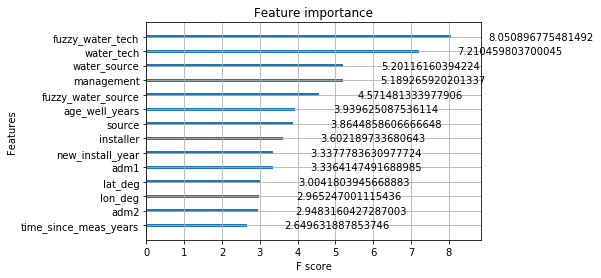

In [29]:
xgb.plot_importance(model_outer, importance_type='gain')

In [30]:
def permutation_importances(model, X_train, y_train, metric):
    baseline = metric( y_train.values,model.predict_proba(X_train))
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy() #store the original
        X_train[col] = np.random.permutation(X_train[col]) #shuffle each column
        m = metric( y_train.values,model.predict_proba(X_train)) #make predictions
        X_train[col] = save # return it back to normal
        imp.append(baseline - m) # if
    return np.array(imp)

#function to plot_perm_importance
# ex: imp = permutation_importances(model_outer, X_test, y_test, metrics.log_loss)
def plot_perm_importance(perm_importance, X_test):
    #takes a permutatino importance and the input data from it and plots
    df = pd.DataFrame(data=abs(perm_importance), index=X_test.columns).sort_values(by=0)
    df.rename(columns={0:'Feature Importance'},inplace=True)
    df.sort_values(by='Feature Importance').plot(kind='barh',
                    title='Feature Importance', legend=None)
    return df.idxmax()[0] #the top feature column name

In [31]:
imp = permutation_importances(model_outer, X_test, y_test, metrics.log_loss)

'age_well_years'

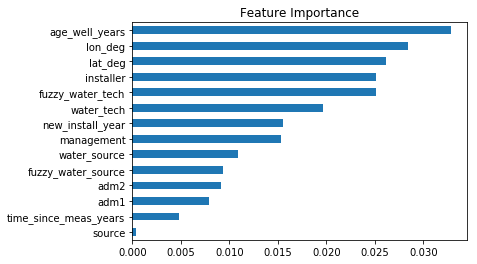

In [32]:
plot_perm_importance(imp,X_test)

# we now how of our early stopped, cross-validated model. We now need to identify the ideal prediction threshold

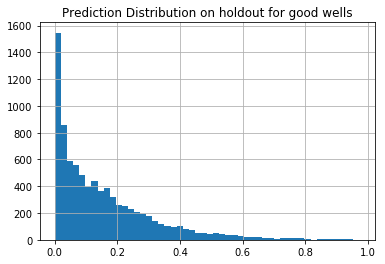

In [33]:
pd.DataFrame(dholdout_predprob[y_holdout==0]).hist(bins=50)
plt.title('Prediction Distribution on holdout for good wells')


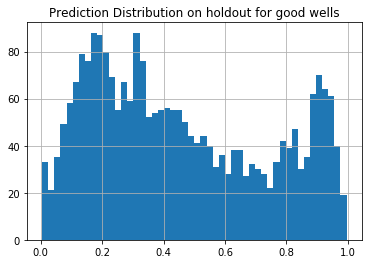

In [34]:
pd.DataFrame(dholdout_predprob[y_holdout==1]).hist(bins=50)
plt.title('Prediction Distribution on holdout for good wells')


(array([ 0.61689941,  0.53572843,  0.90911491,  1.12015945,  1.44484335,
         1.50978013,  1.68835627,  1.80199563,  1.62341949,  1.21756462,
         1.31496979,  1.20133042,  1.72082466,  1.2825014 ,  1.15262784,
         1.12015945,  1.2662672 ,  0.97405169,  1.13639364,  0.84417813,
         0.84417813,  0.9415833 ,  0.66560199,  0.66560199,  0.53572843,
         0.81170974,  0.68183619,  0.61689941,  0.55196263,  0.50326004,
         0.53572843,  0.92534911,  0.79547555,  0.86041233,  0.55196263,
         1.25003301,  1.36367237,  1.41237496,  0.90911491,  0.43832326]),
 array([ 0.00446961,  0.02925768,  0.05404576,  0.07883384,  0.10362192,
         0.12841   ,  0.15319807,  0.17798615,  0.20277423,  0.22756231,
         0.25235038,  0.27713846,  0.30192654,  0.32671462,  0.3515027 ,
         0.37629077,  0.40107885,  0.42586693,  0.45065501,  0.47544309,
         0.50023116,  0.52501924,  0.54980732,  0.5745954 ,  0.59938347,
         0.62417155,  0.64895963,  0.67374771,  0

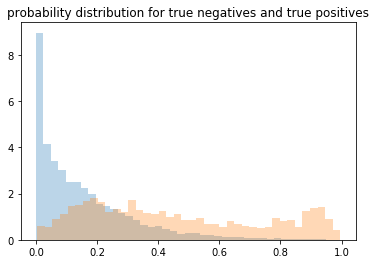

In [35]:

x1 = dholdout_predprob[y_holdout==0]
x2 = dholdout_predprob[y_holdout==1]


kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

plt.title('probability distribution for true negatives and true positives')
plt.hist(x1, **kwargs)
plt.hist(x2, **kwargs)


### This is a much better spread than our small holdout last time. I wonder if this is from the target leakage from the repeat measurements? Could that even be target leakage?

In [36]:
#try a bunch of different prediction thresholds < 0.5 and see which one maximizes recall and F1 score
import numpy as np
d = dict()
for i in np.linspace(0,0.5, num=20):
    best = 0
    test = np.where(dtest_predprob > i, 1,0)
    recall = metrics.recall_score(y_test, test)
    precision = metrics.precision_score(y_test, test)
    f_score = metrics.f1_score(y_test, test, average='binary')
    d[i]=recall, precision, f_score
    
frame = pd.DataFrame.from_dict(d, orient='index')#.columns=(['recall', 'f1_score'])
frame.columns=(['recall','precision', 'f1_score'])
frame

,recall,precision,f1_score
0.000000,1.000000,0.226465,0.369297
0.026316,0.989940,0.271583,0.426232
0.052632,0.975855,0.296818,0.455185
0.078947,0.954527,0.322151,0.481722
0.105263,0.925553,0.347065,0.504829
0.131579,0.886519,0.368333,0.520435
0.157895,0.843058,0.390785,0.534030
0.184211,0.810463,0.417669,0.551252
0.210526,0.777867,0.446936,0.567695
0.236842,0.733199,0.473493,0.575399


In [37]:
def top_feat_table(df,feat):
    """
    returns functioning and non-functioning wells by the most important
    (or any) feature
    args: un-label encoded data frame; top feature (string)
    returns: dataframe
    """
    #shows what of the top features failed in the training data
    gp = df.groupby([feat, 'status_binary']).size().unstack()
    gp['percentage_broken'] = round(gp[1]/gp.sum(axis=1)*100,2)
    gp.reset_index(inplace=True)
    gp.rename(columns={0:'# functioning', 1:'# not functioning'},index={'status_binary':'index'},  inplace=True)
    gp.sort_values(by='# not functioning', ascending =False, inplace=True)
    gp.rename_axis('index', axis='columns').fillna(0, inplace=True)
    return gp

In [50]:
top_feat_table(sl, 'installer').sort_values(by='# not functioning', ascending =False)

status_binary,installer,# functioning,# not functioning,percentage_broken
562,Government,1933.0,1006.0,34.23
1052,Private Person,7280.0,805.0,9.96
956,Other,1926.0,802.0,29.40
523,GVWC,1124.0,576.0,33.88
1292,United Nations (UN),1755.0,534.0,23.33
1147,SALWACO,1037.0,508.0,32.88
1441,__MISSING__,4425.0,489.0,9.95
1296,Unknown,783.0,487.0,38.35
1090,Religious Group,1968.0,458.0,18.88
14,:Don't know,684.0,386.0,36.07



### Create predictions for the out years based on data

In [12]:
model_outer = pickle.load(open('Sierra Leone Holdout using TVH No Pay_pickle.sav', 'rb'))

In [14]:
X_today = X2.copy()
X_today['age_well_years'] = X_today.age_well_years + X_today.time_since_meas_years
X_today[:1]

,water_source,water_tech,management,source,adm1,adm2,installer,lat_deg,lon_deg,new_install_year,age_well_years,time_since_meas_years,fuzzy_water_source,fuzzy_water_tech
42474,93,5,1,2,4,48,952,8.14546,-10.7758,69,7.2,6.0,8,4


In [46]:
X_today.age_well_years.describe()

count    54864.000000
mean        41.775148
std         80.916676
min          1.100000
25%          8.200000
50%         12.200000
75%         26.200000
max        280.200000
Name: age_well_years, dtype: float64

In [15]:
#make two other future values to predict, 1 year and 5 years
X_1year = X_today.copy()
X_1year['age_well_years'] = X_1year.age_well_years + 1
X_3year = X_1year.copy()
X_3year['age_well_years']=X_3year.age_well_years+2
X_5year = X_1year.copy()
X_5year['age_well_years']=X_5year.age_well_years+4

In [16]:
print(X2[['age_well_years', 'time_since_meas_years']][:1])
print(X_today[['age_well_years', 'time_since_meas_years']][:1])
print(X_1year[['age_well_years', 'time_since_meas_years']][:1])
print(X_3year[['age_well_years', 'time_since_meas_years']][:1])
print(X_5year[['age_well_years', 'time_since_meas_years']][:1])

       age_well_years  time_since_meas_years
42474             1.2                    6.0
       age_well_years  time_since_meas_years
42474             7.2                    6.0
       age_well_years  time_since_meas_years
42474             8.2                    6.0
       age_well_years  time_since_meas_years
42474            10.2                    6.0
       age_well_years  time_since_meas_years
42474            12.2                    6.0


# Get Predictions for Today, 1, 3 and 5 years out

In [17]:
today_preds = model_outer.predict(X_today)
today_predprob = model_outer.predict_proba(X_today)
one_year_preds = model_outer.predict(X_1year)
one_year_predprob = model_outer.predict_proba(X_1year)
three_year_preds = model_outer.predict(X_3year)
three_year_predprob = model_outer.predict_proba(X_3year)
five_year_preds = model_outer.predict(X_5year)
five_year_predprob = model_outer.predict_proba(X_5year)

In [18]:
# append them to the original df
sl['today_preds']=today_preds
sl['today_predprob']= today_predprob[:,1]
sl['one_year_preds'] = one_year_preds
sl['one_year_predprob'] = one_year_predprob[:,1]
sl['three_year_preds'] = three_year_preds
sl['three_year_predprob']= three_year_predprob[:,1]
sl['five_year_preds']=five_year_preds
sl['five_year_predprob'] =five_year_predprob[:,1]

In [56]:
#OLD PREDICTIONS WITH IMPROPER TIME SINCE MEASUREMENT CALC
#sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,54864.000000,54864.000000,54864.000000,54864.000000,54864.000000
mean,0.226487,0.135189,0.115558,0.118037,0.116142
std,0.418562,0.341928,0.319698,0.322655,0.320398
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
#with corrected time to measure
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,54864.000000,54864.000000,54864.000000,54864.000000,54864.000000
mean,0.226487,0.135189,0.135790,0.138743,0.140329
std,0.418562,0.341928,0.342569,0.345681,0.347331
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


# Modeling Decision - use 0.289474 as the threshold to keep ~50% precision and  ~65% recall

In [20]:
threshold = 0.289474
#recall > 90%, we want to catch all of the bad wells
sl['today_preds']=np.where(today_predprob[:,1]>threshold,1,0)
sl['today_predprob']= today_predprob[:,1]
sl['one_year_preds'] = np.where(one_year_predprob[:,1]>threshold,1,0)
sl['one_year_predprob'] = one_year_predprob[:,1]
sl['five_year_preds']=np.where(five_year_predprob[:,1]>threshold,1,0)
sl['five_year_predprob'] =five_year_predprob[:,1]

In [33]:
#old way with incorrect time to measure
#sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,54864.000000,54864.000000,54864.000000,54864.000000,54864.000000
mean,0.226487,0.253390,0.258567,0.117800,0.254411
std,0.418562,0.434956,0.437851,0.322375,0.435534
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
#new results with corrected time to measure
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,54864.000000,54864.000000,54864.000000,54864.000000,54864.00000
mean,0.226487,0.302092,0.308180,0.138743,0.32298
std,0.418562,0.459169,0.461746,0.345681,0.46762
min,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.000000,1.000000,1.000000,0.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.00000


In [22]:
#how many wells that were good at time of measurement do we predict will fail within one year from today?
sl[sl.status_binary==0][(sl.today_preds<sl.one_year_preds)].shape

(671, 48)

In [23]:
#how many wells that were good at time of measurement do we predict will fail within one year from today?
sl[sl.status_binary==0][(sl.today_preds<sl.one_year_preds)&(sl.one_year_preds<sl.five_year_preds)].shape

(0, 48)

In [24]:
print(metrics.classification_report(y_holdout, dholdout_predictions))

             precision    recall  f1-score   support

        0.0       0.84      0.96      0.90      8488
        1.0       0.72      0.39      0.51      2485

avg / total       0.82      0.83      0.81     10973



In [62]:
sl.to_csv('Sierra_Leone_w_outyear_predictions.csv')

In [ ]:
sl = pd.read_csv('Sierra_Leone_w_outyear_predictions.csv')

# Ensure that if a waterpoint was ever marked as bad, it shows as bad for all points in the future

In [25]:
def append_outyear_predictions(original_df, threshold, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob):
    sl = original_df.copy()
    #ensures if a well was ever bad, it is bad in the future
    sl['today_preds']=np.where(sl.status_binary==1,1,np.where(today_predprob[:,1]>threshold,1,0))
    sl['today_predprob']= today_predprob[:,1]
    sl['one_year_preds'] = np.where(np.max(sl[['status_binary','today_preds']], axis = 1)>0,
                                    1,np.where(one_year_predprob[:,1]>threshold,1,0))
    sl['one_year_predprob'] = one_year_predprob[:,1]
    sl['three_year_preds'] = np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds']], axis = 1)>0,1,
                                      np.where(three_year_predprob[:,1]>threshold,1,0))
    sl['three_year_predprob']= three_year_predprob[:,1]
    sl['five_year_preds']=np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds', 'three_year_preds']], axis = 1)>0,
                                   1,np.where(five_year_predprob[:,1]>threshold,1,0))
    sl['five_year_predprob'] =five_year_predprob[:,1]
    
    
    return sl

In [64]:
#OLD with imprope time since measurement
#coerced = append_outyear_predictions(sl, 0.289474, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [65]:
#coerced[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,54864.000000,54864.000000,54864.00000,54864.000000,54864.000000
mean,0.226487,0.351414,0.36678,0.375893,0.388050
std,0.418562,0.477416,0.48193,0.484357,0.487311
min,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.000000,1.000000,1.00000,1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000


In [29]:
coerced2 = append_outyear_predictions(sl, 0.289474, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [30]:
coerced2[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,54864.000000,54864.000000,54864.000000,54864.000000,54864.000000
mean,0.226487,0.351414,0.363645,0.375492,0.383147
std,0.418562,0.477416,0.481052,0.484254,0.486158
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
print(coerced2[coerced2.status_binary==0][(coerced2.today_preds<coerced2.one_year_preds)].shape)

(671, 48)


In [42]:
coerced2.to_csv('Sierra_Leone_w_outyear_predictions_coerced_no_pay_correct_time2.csv')

# Examine the age of the wells by the water source, tech

[None, None, None, None, None, None, None, None, None, None, None, None]

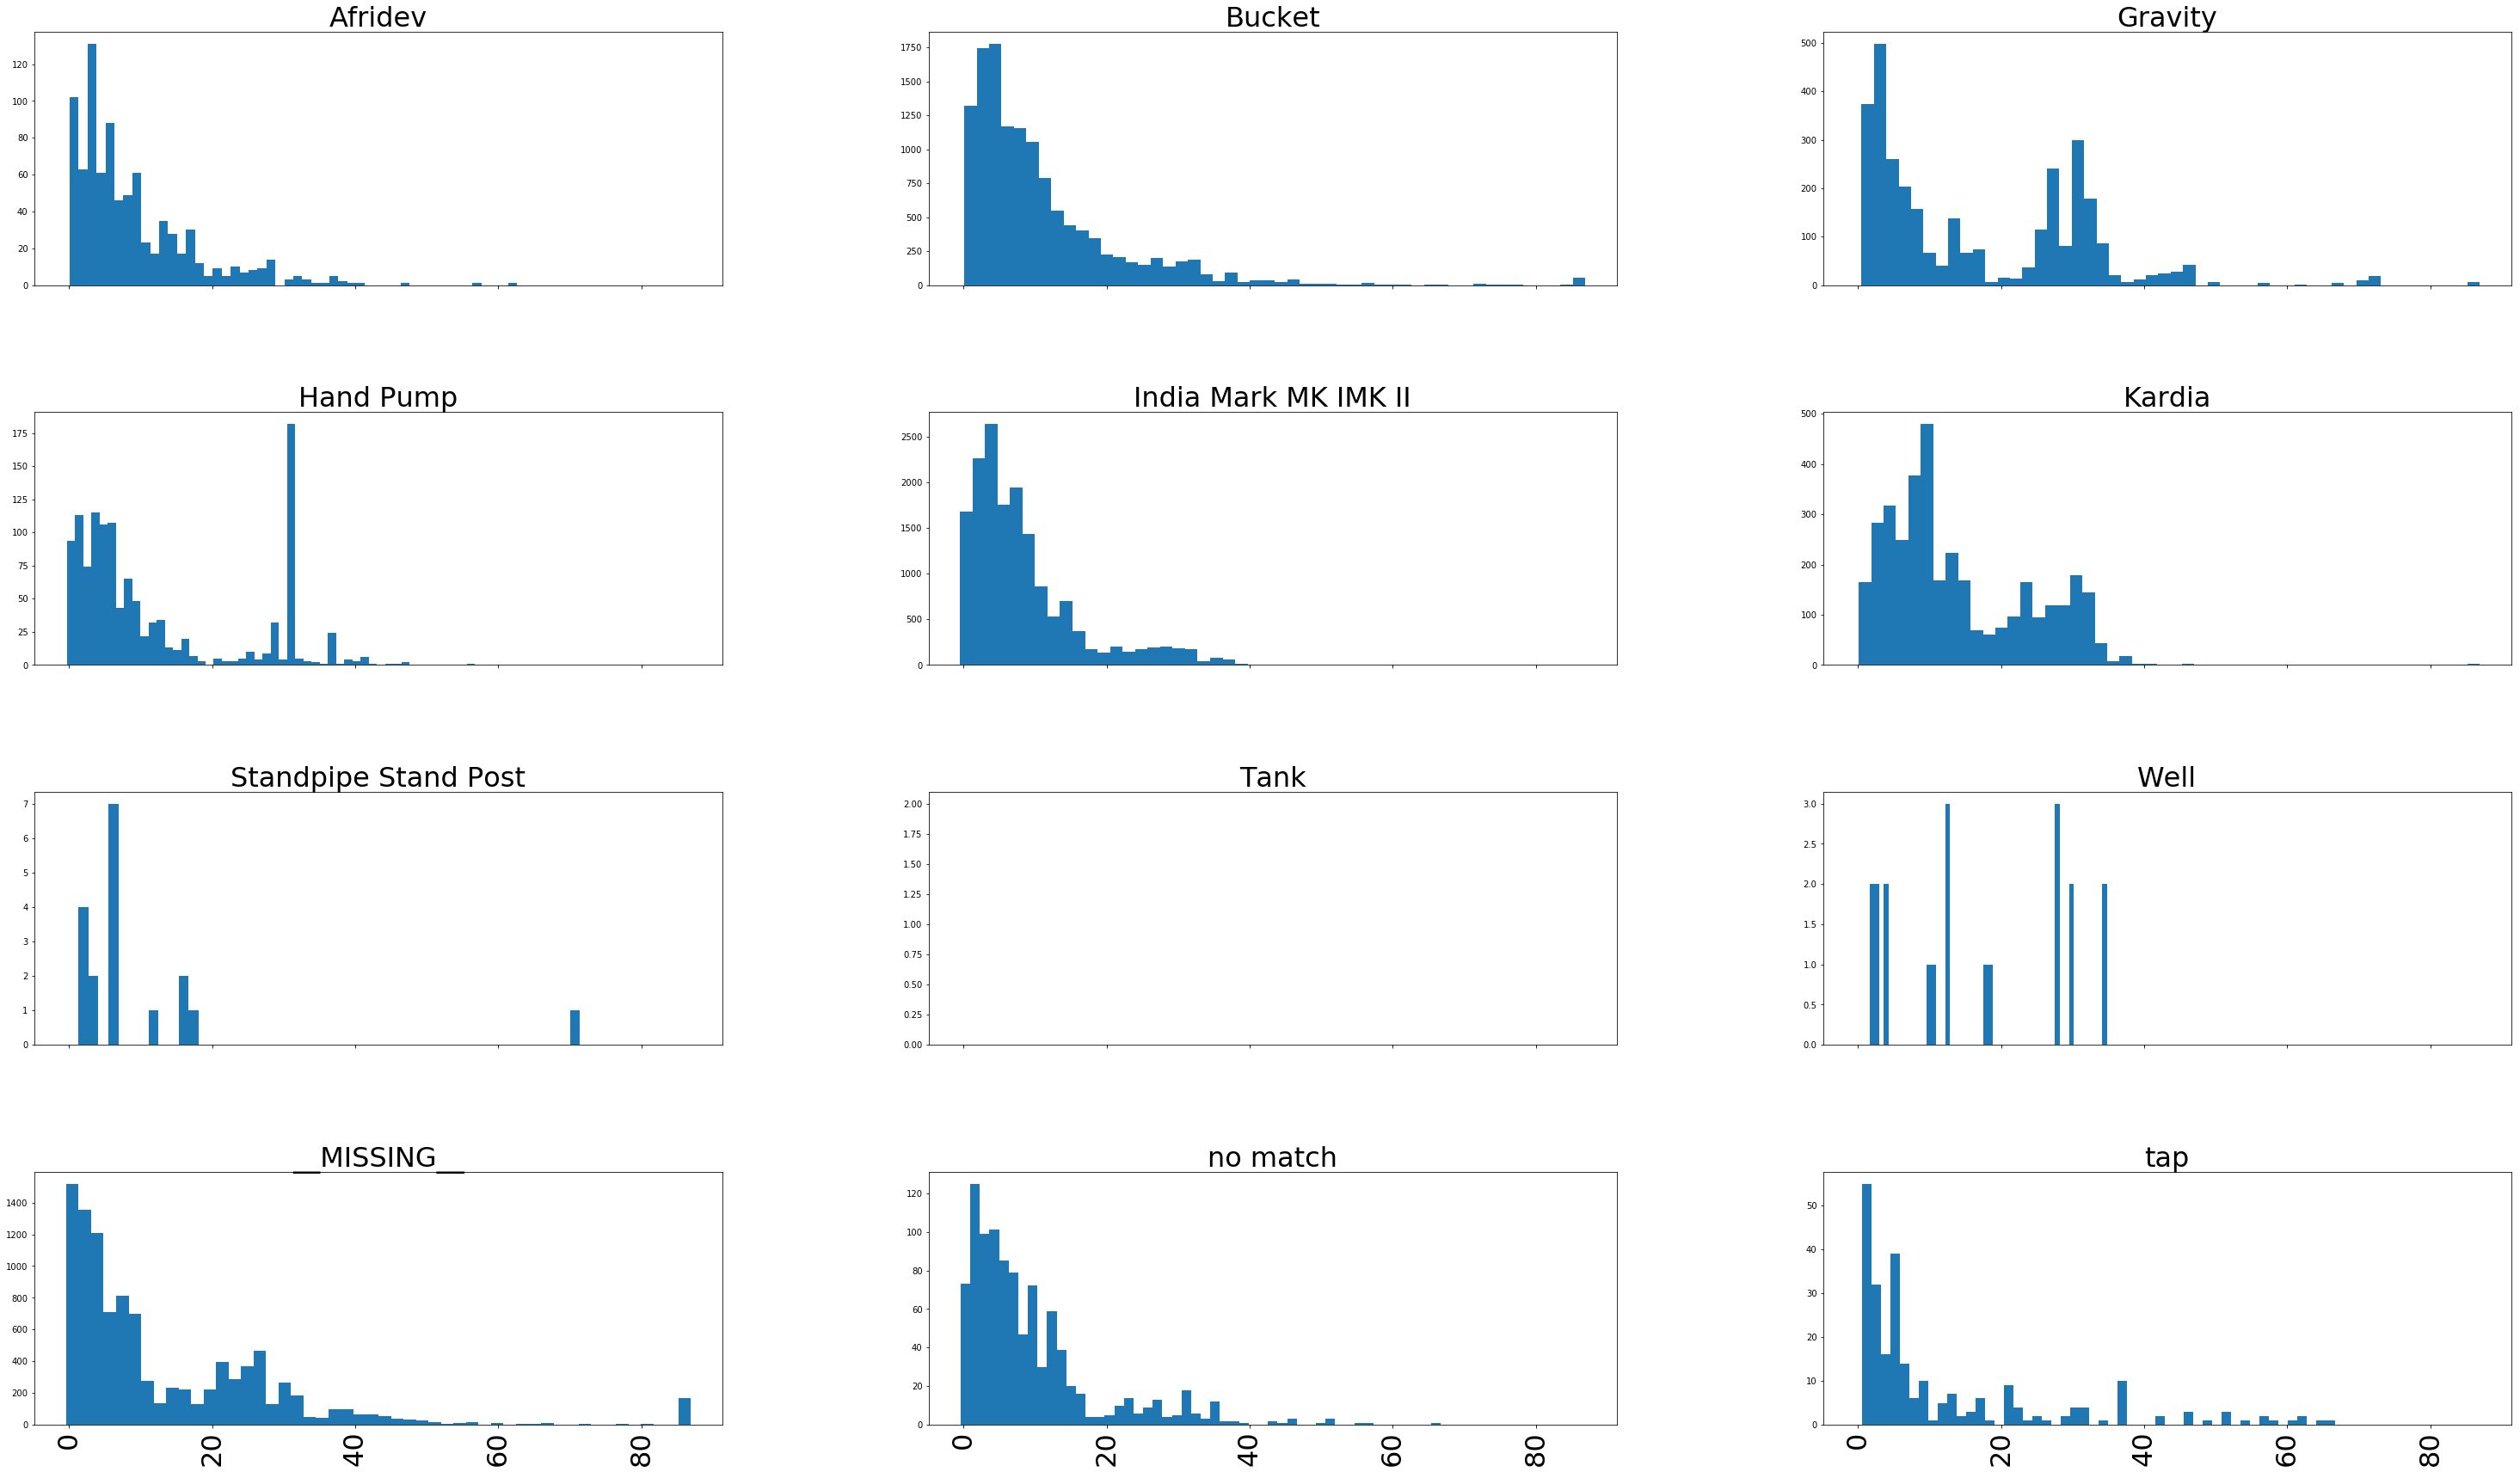

In [32]:
plt.rcParams['xtick.labelsize'] = 32
#exclude missing values for well age - 274
fig = sl[sl.age_well_years!=274].hist('age_well_years', by='fuzzy_water_tech', bins=50, sharex=True,figsize=(50,30))
[x.title.set_size(32) for x in fig.ravel()]


[None, None, None, None, None, None, None, None, None, None, None, None]

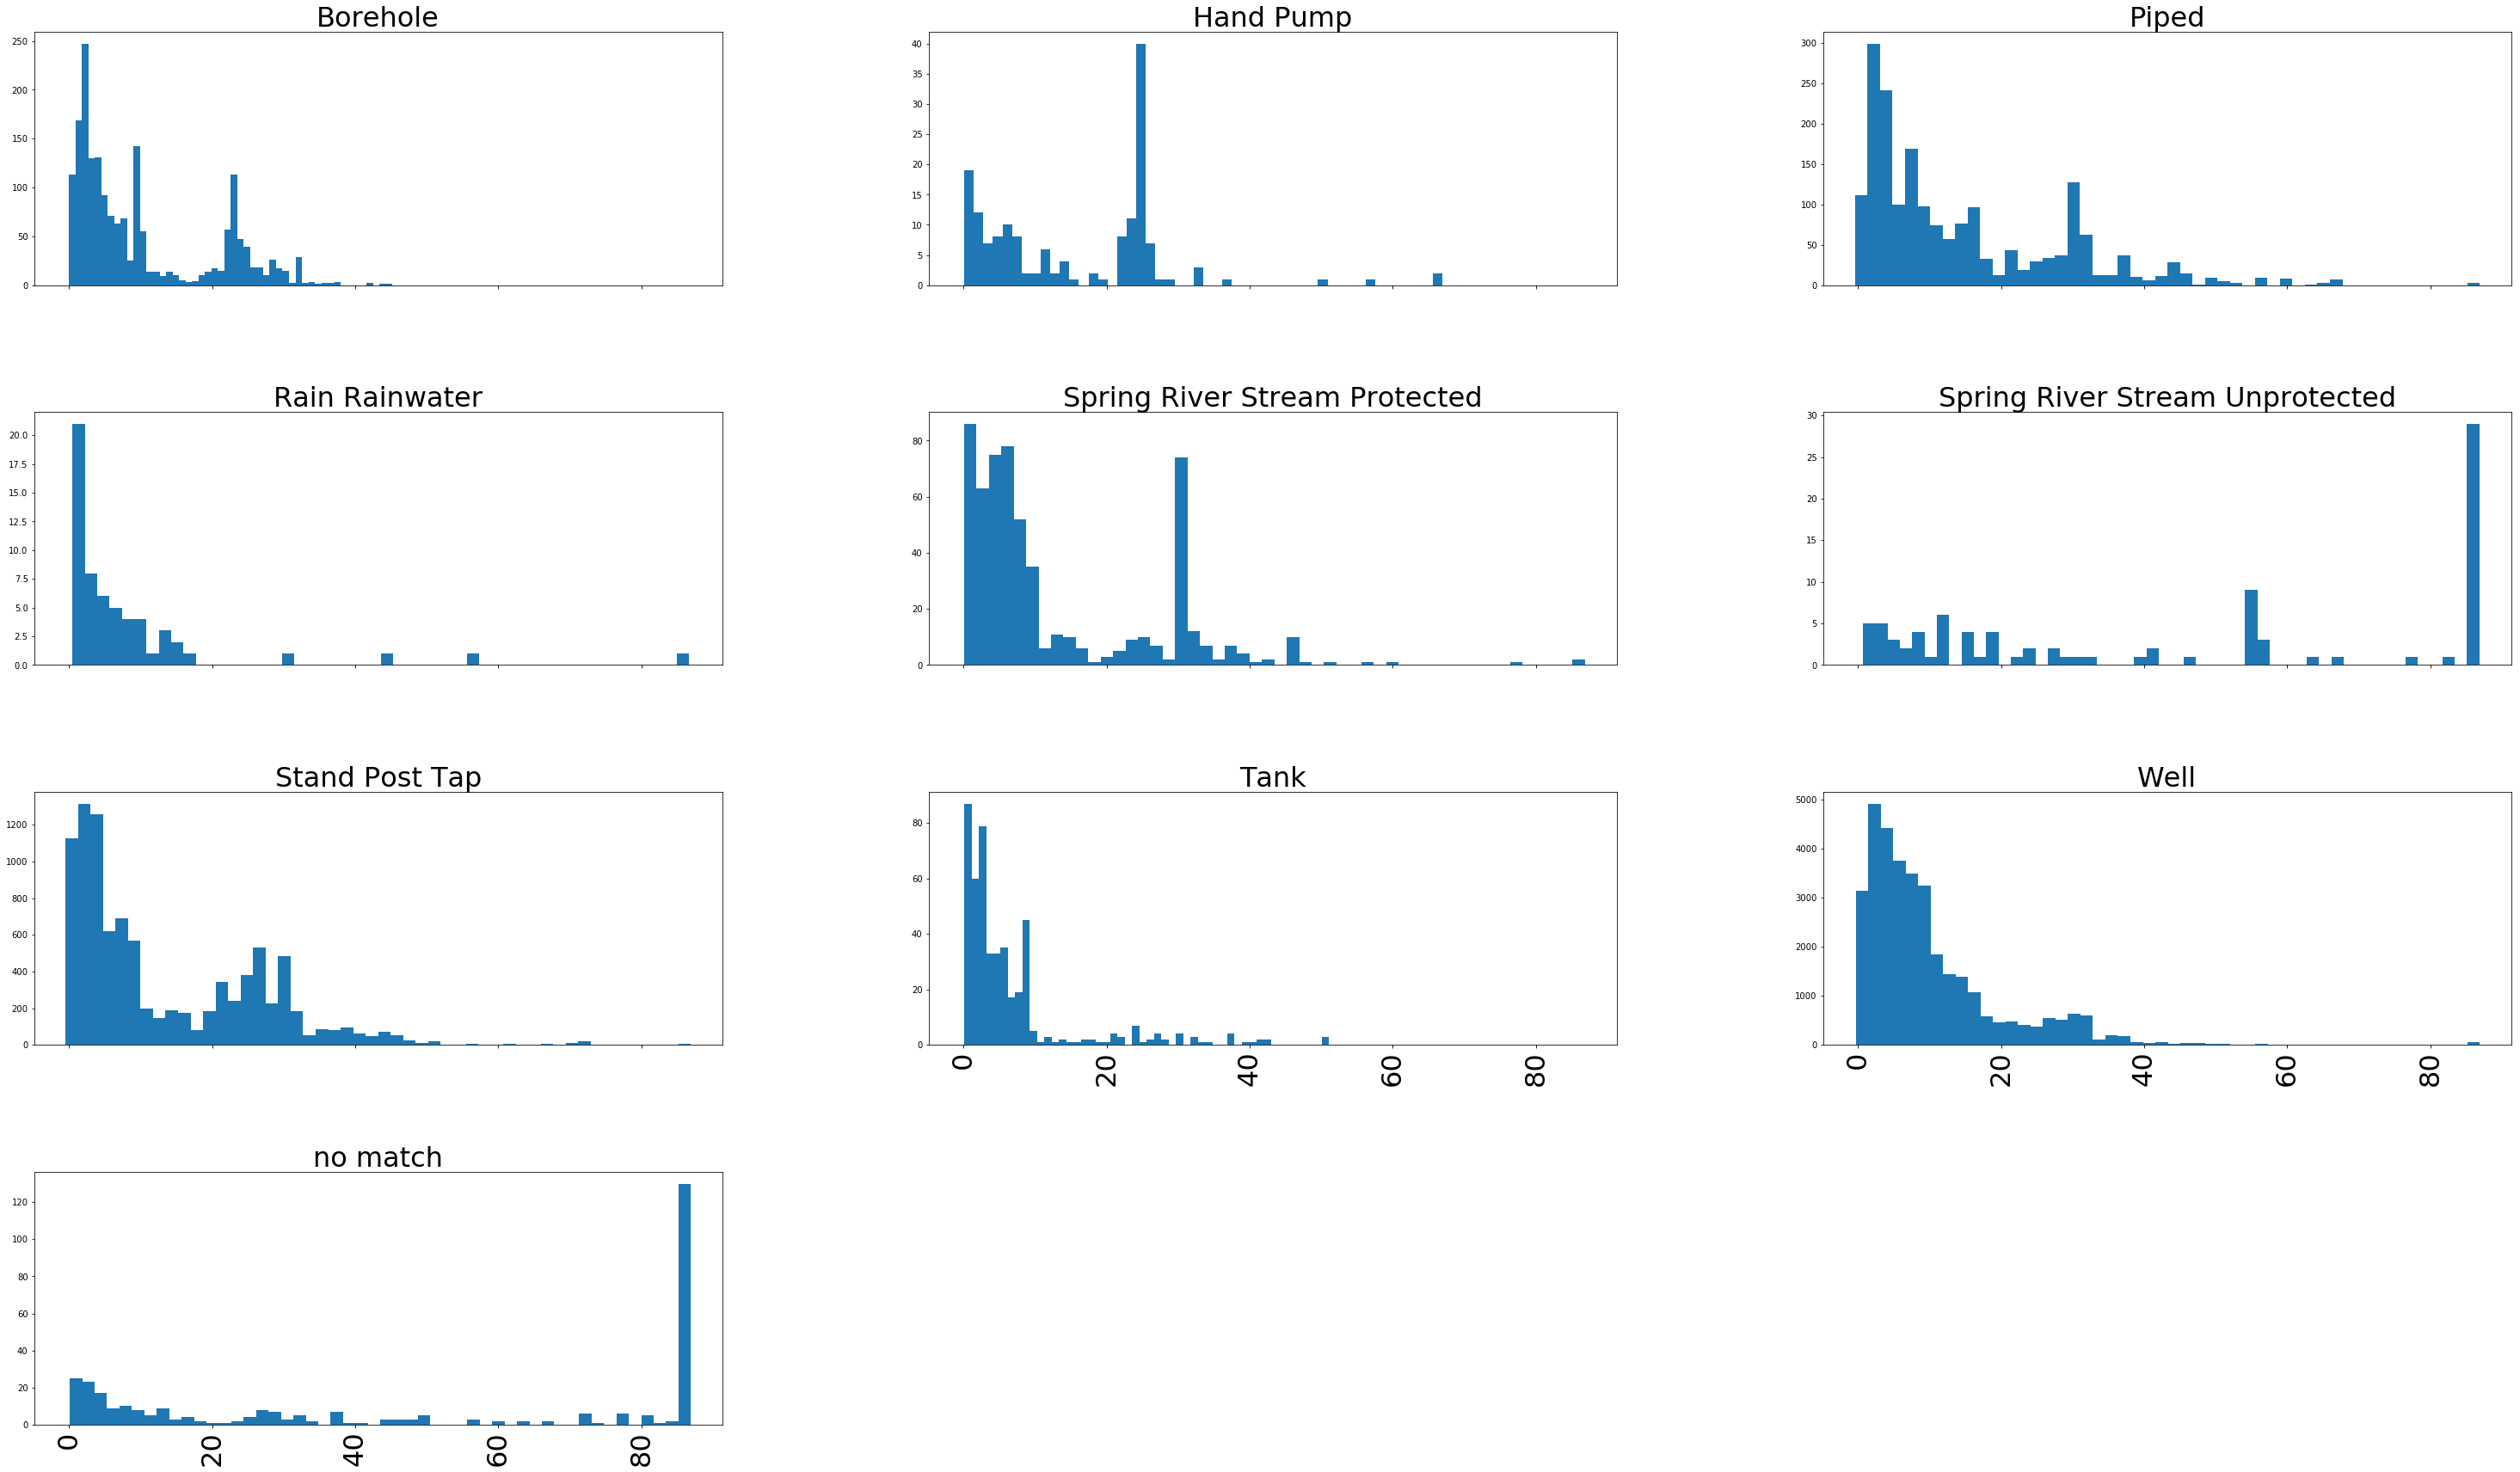

In [34]:
plt.rcParams['xtick.labelsize'] = 32
#exclude missing values for well age - 274
fig = sl[sl.age_well_years!=274].hist('age_well_years', by=['fuzzy_water_source'], bins=50,sharex=True, figsize=(50,30))
[x.title.set_size(32) for x in fig.ravel()]


In [ ]:
%matplotlib inline

In [ ]:
import seaborn as sns
sns.set(style='darkgrid')
cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 10, 6

gp = sl.groupby(['fuzzy_water_tech','age_well_years']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,15), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0], robust=True, square=False, cbar=False)

In [ ]:
gp = df.groupby(['fuzzy_water_source','age_well_years']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,15), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0], robust=True, square=False, cbar=False)

In [ ]:
gp = df.groupby(['fuzzy_water_tech','status_binary','age_well_years']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,15), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0], robust=True, square=False, cbar=False)
plt.xticks(rotation=90)

In [ ]:
import seaborn as sns
gp = sl.groupby(['fuzzy_water_tech','today_preds']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,15), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0], robust=True, square=False, cbar=True)
#plt.xticks(rotation=90)